# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

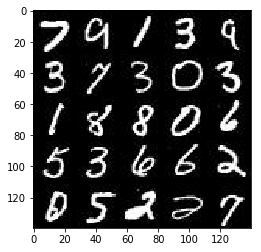

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

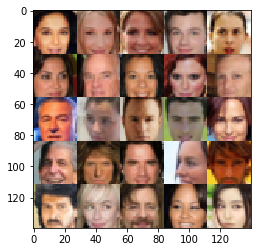

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), keep_prob=0.8)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.dropout(tf.maximum(alpha * bn2, bn2), keep_prob=0.8)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.dropout(tf.maximum(alpha * bn3, bn3), keep_prob=0.8)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), keep_prob=0.5)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(tf.maximum(alpha * x2, x2), keep_prob=0.5)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(tf.maximum(alpha * x3, x3), keep_prob=0.5)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.dropout(tf.maximum(alpha * x4, x4), keep_prob=0.5)
        # 32x32x64 now
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # 32x32x3 now
        
        logits = tf.image.resize_images(logits, size=[28, 28])
        # 28x28x3 now
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)*0.9))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                ######## the value of the original dataset ranges from -0.5 to 0.5
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epoch_count),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6850... Generator Loss: 1.4980
Epoch 1/2... Discriminator Loss: 2.7859... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 3.8232... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 2.3294... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 2.3414... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.5812... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.7186... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.5875... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.5458... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.9197


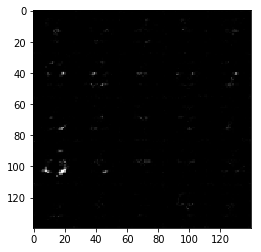

Epoch 1/2... Discriminator Loss: 1.7488... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 1.1013
Epoch 1/2... Discriminator Loss: 1.6976... Generator Loss: 0.8227
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.8870


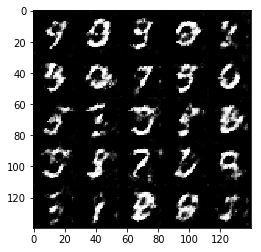

Epoch 1/2... Discriminator Loss: 1.3643... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 1.1912
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 1.1443
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.9999
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 1.0801
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.7734


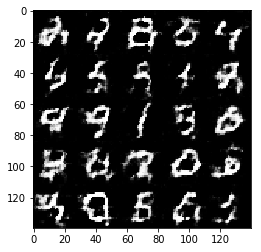

Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 1.0038
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.8225
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.6538


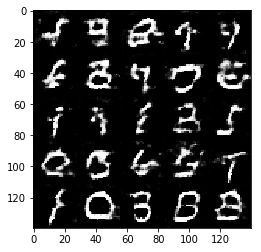

Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.7339
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 1.2120
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 0.9357


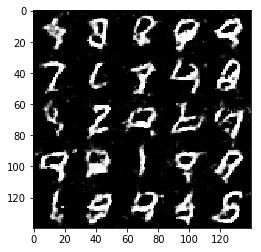

Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 1.1396
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 1.2481
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.1915


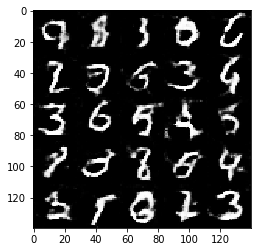

Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 1.0174
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 1.3628
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.9988


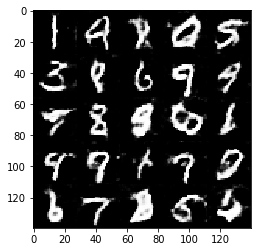

Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 1.1952
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 1.1158


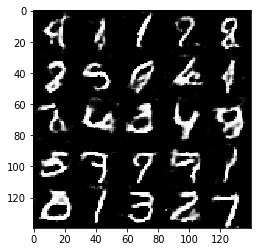

Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 1.3399
Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 1.1380
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 1.0885


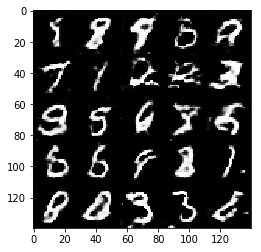

Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.8833
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 1.3650
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.6439


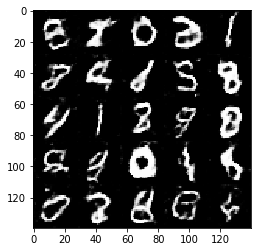

Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 1.1333
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.9396
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 1.1741
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.9598


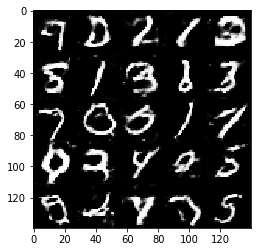

Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 0.9763
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 1.7036
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 1.3954
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 1.3188
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.9229
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 1.1871
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 1.5110


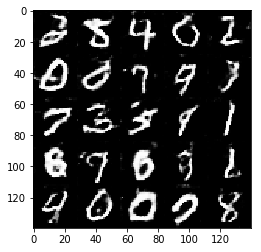

Epoch 2/2... Discriminator Loss: 1.5016... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 1.0565
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 1.2885
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.9283


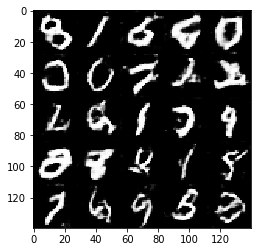

Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.8774
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 1.1234
Epoch 2/2... Discriminator Loss: 1.1203... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 1.1935


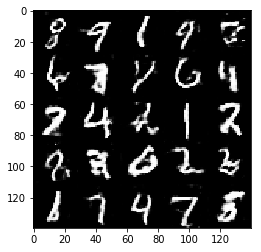

Epoch 2/2... Discriminator Loss: 1.0115... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 1.3645
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 0.9749
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.8886
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 1.5893
Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 1.5427


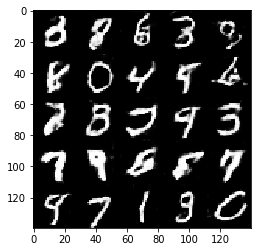

Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.9204
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 1.6614
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.6286
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.1001


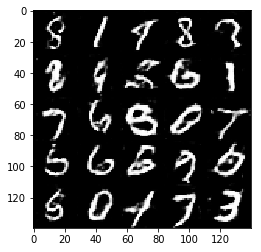

Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 1.4052
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 1.2456
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 1.0612
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.5531
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 2.3462... Generator Loss: 0.4015
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 1.3737


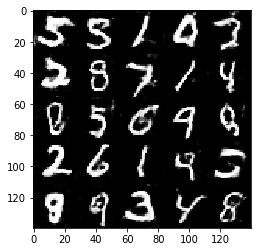

Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: 1.1624... Generator Loss: 1.1592
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.3252
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 1.3940
Epoch 2/2... Discriminator Loss: 2.0983... Generator Loss: 0.3977
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 1.5336
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 1.3053
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 1.4497
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 1.2856


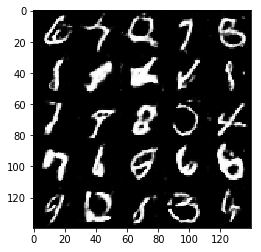

Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 1.0689
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.6501
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 1.2983


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8141... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 2.7456... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 2.9429
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 3.1862
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.9172
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 3.1787
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.5323


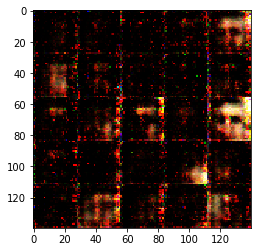

Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.8149
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.8411
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 2.3758
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.0979


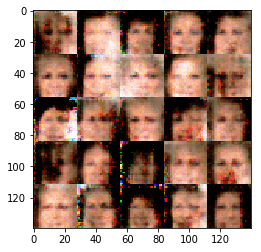

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.8372
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.0729


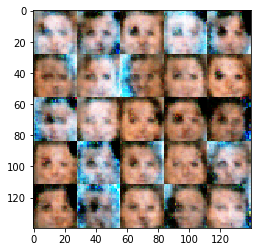

Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 1.2900
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7239


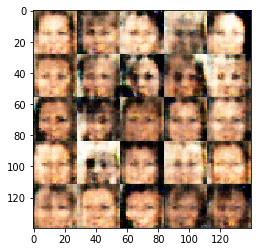

Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 1.0905


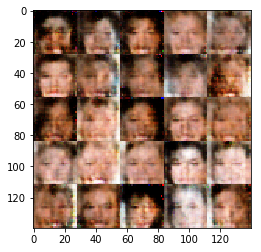

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.7224... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 1.0246


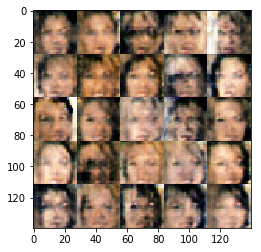

Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.6684... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7158


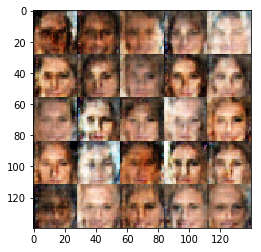

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7989


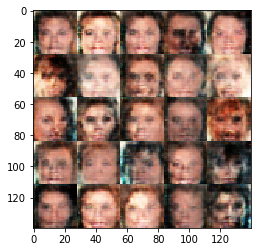

Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8840


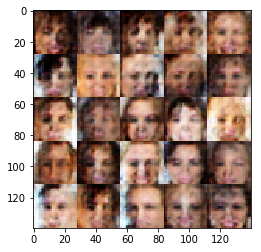

Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.7243


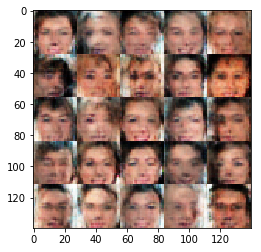

Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8768


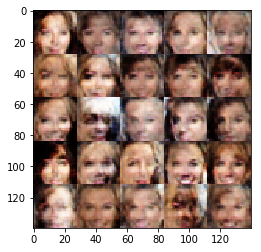

Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0149


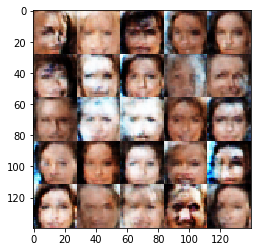

Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8348


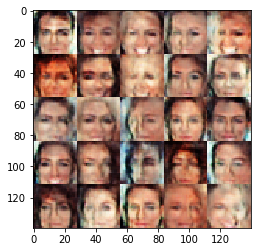

Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7947


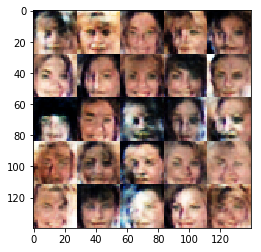

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8962


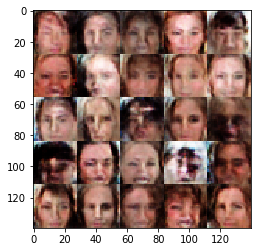

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8271


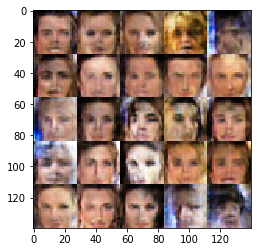

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9214


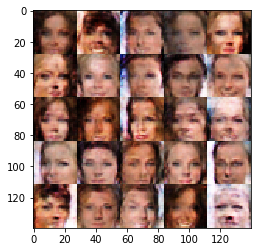

Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8302


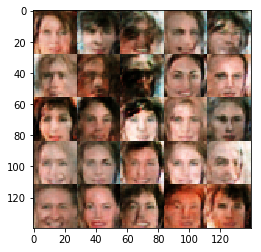

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8313


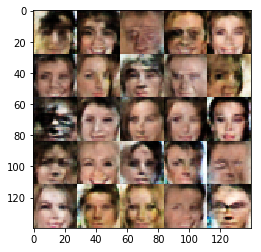

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8942


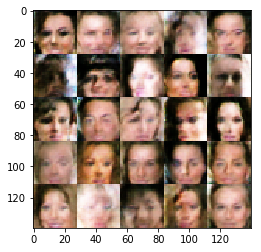

Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8110


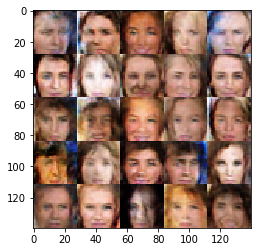

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.8869


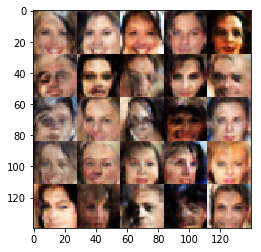

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.9447


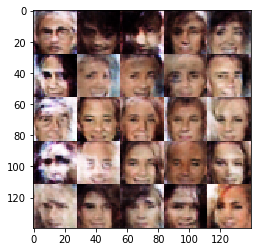

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8364


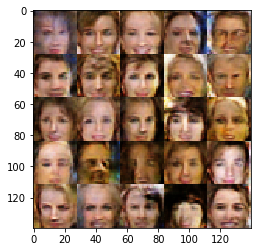

Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8802


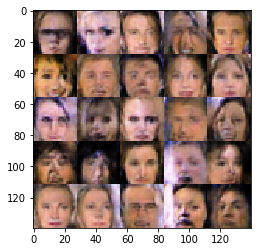

Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8539


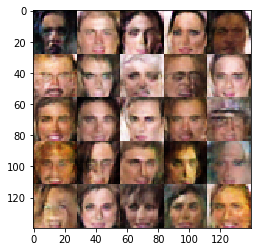

Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7984


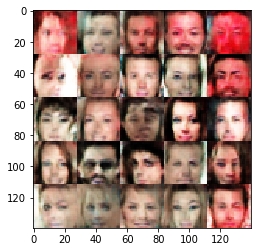

Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8053


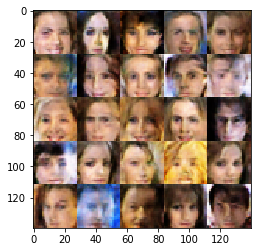

Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.0303
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8205


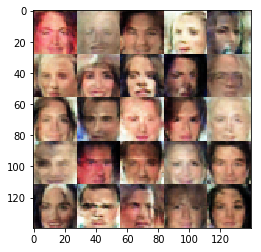

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8034


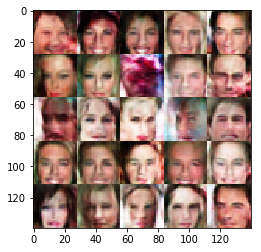

Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8606


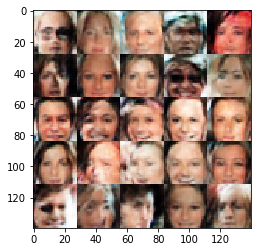

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8557


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.